# K-means 主要原理

![kmeans](./img/k-means.png)

# 准备工作

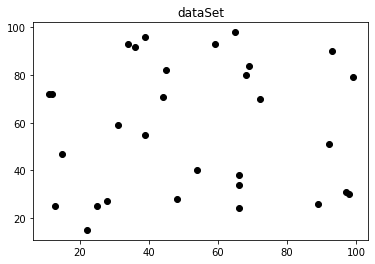

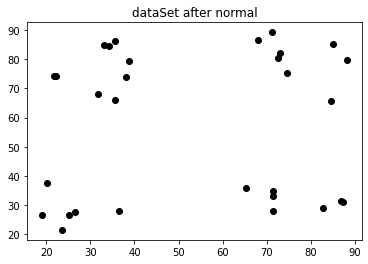

In [150]:
# 初始化
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# 算法超参数
k = 4
epsilon = 0.001

# 构造数据集
random.seed(200)
dataSet = pd.DataFrame({
    "x":[random.randint(10, 99) for _ in range(30)],
    "y":[random.randint(10, 99) for _ in range(30)]
})
plt.title("dataSet")
plt.scatter(dataSet["x"], dataSet["y"], color = "k", marker = "o")
plt.show()
# 将随机化的数据做一下处理，使得其具有“聚类”的特点
data_k0 = dataSet[(dataSet["x"] < 50) & (dataSet["y"] < 50)]
data_k1 = dataSet[(dataSet["x"] >= 50) & (dataSet["y"] < 50)]
data_k2 = dataSet[(dataSet["x"] < 50) & (dataSet["y"] >= 50)]
data_k3 = dataSet[(dataSet["x"] >= 50) & (dataSet["y"] >= 50)]
means_k0 = np.mean(data_k0, axis=0)
means_k1 = np.mean(data_k1, axis=0)
means_k2 = np.mean(data_k2, axis=0)
means_k3 = np.mean(data_k3, axis=0)
dataSet[(dataSet["x"] < 50) & (dataSet["y"] < 50)] = np.add(data_k0, means_k0) / 2
dataSet[(dataSet["x"] >= 50) & (dataSet["y"] < 50)] = np.add(data_k1, means_k1) / 2
dataSet[(dataSet["x"] < 50) & (dataSet["y"] >= 50)] = np.add(data_k2, means_k2) / 2
dataSet[(dataSet["x"] >= 50) & (dataSet["y"] >= 50)] = np.add(data_k3, means_k3) / 2
plt.title("dataSet after normal")
plt.scatter(dataSet["x"], dataSet["y"], color = "k", marker = "o")
plt.show()

In [151]:
# 欧氏距离计算公式
def distEclud(vecA, vecB):
    return np.linalg.norm(vecA - vecB)

In [152]:
# 初始化质心
def randCenters(dataSet, k):
    np.random.seed(200)
    n = np.shape(dataSet)[1]
    cluster_cents = np.mat(np.zeros((k, n)))   # 初始化聚类中心矩阵：k*n
    for col in range(n):
        mincol = np.min(dataSet.iloc[:, col])
        maxcol = np.max(dataSet.iloc[:, col])
        # random.rand(k, 1):产生一个0~1之间的随机数向量（k,1表示产生k行1列的随机数）
        cluster_cents[:, col] = np.mat(mincol + (maxcol - mincol) * np.random.rand(k, 1))
    return cluster_cents

# 训练

In [153]:
m, n = np.shape(dataSet)
flag = True
count = 0

# SSE loss 记录
count_loss = []
loss = 0

# 核心的数据结构：
#   col0：sample 对应的聚类中心
#   col1: sample 到其聚类中心的欧式距离
sample_ClustDist = np.mat(np.zeros((m,2)))

# 初始化簇心
cluster_cents = randCenters(dataSet, k)
count_cluster_cents = []
count_cluster_cents.append(cluster_cents.copy())

while flag:
    flag = False
    count += 1
    # --- 1. 将每个样本划分到对应的簇，并填写 sample_ClustDist ---
    for i in range(m):
        # 单样本计算
        nodei_distlist = [distEclud(dataSet.iloc[i, :].tolist(), cluster_cents[j, :]) for j in range(k)]
        nodei_minDist = np.min(nodei_distlist)
        loss += nodei_minDist
        nodei_minIndex = nodei_distlist.index(nodei_minDist)

        # 收敛性判断
        if sample_ClustDist[i, 0] != nodei_minIndex:
            flag = True

        # 更新样本所属簇
        sample_ClustDist[i, :] = nodei_minIndex, nodei_minDist

    # 一轮分配完毕，保存一下当前的 SSE，即 loss
    count_loss.append(loss)
    loss = 0

    # --- 2. 更新每个簇的簇心 ---
    for cent in range(k):
        dInx = np.nonzero(sample_ClustDist[:, 0].A == cent)[0]  # 对应簇样本的索引
        nodeInClust = dataSet.loc[dInx.tolist(), :]             # 获取对应样本
        cluster_cents[cent, :] = np.mean(nodeInClust, axis=0)
    count_cluster_cents.append(cluster_cents.copy())

# print(count_cluster_cents)
# print(count)

# 效果展示

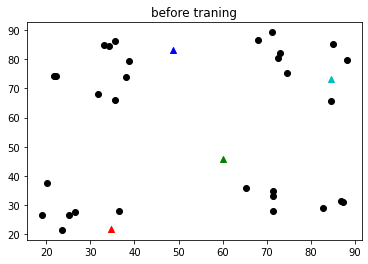

In [154]:
innitial_cluster_cents = randCenters(dataSet, k)
plt.title("before traning")
colormap = {0: "c", 1: "r", 2: "g", 3:"b"}

# 绘制点，此时的点是没有被聚类的，用黑色表示
plt.scatter(dataSet["x"], dataSet["y"], color = "k", marker = "o")

# 利用不同颜色表示每个簇中心
for i in range(k):
    plt.scatter(innitial_cluster_cents[i, 0], innitial_cluster_cents[i, 1], color=colormap[i], marker="^")

plt.show()

<ipython-input-155-6c32f03d1f6f>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


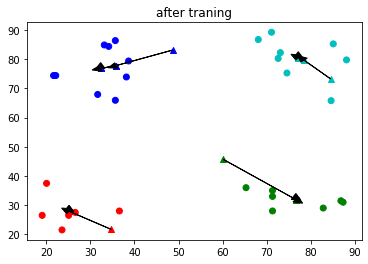

In [155]:
plt.title("after traning")
ax = plt.axes()
colormap = {0: "c", 1: "r", 2: "g", 3:"b"}

# 根据训练的 sample_ClustDist 将每个样本划分到不同的簇，用颜色表示
plt.scatter(dataSet["x"], dataSet["y"], color = list(map(lambda x : colormap[x], [item[0] for item in sample_ClustDist.tolist()])) , marker="o")

# 利用不同颜色标识出不同的簇中心，并用箭头标识其移动情况
for round in range(len(count_cluster_cents)):
    if round > 0:
        old_cluster_cents = count_cluster_cents[round - 1]
        cluster_cents = count_cluster_cents[round]
        for i in range(k):
            old_x = old_cluster_cents[i, 0]
            old_y = old_cluster_cents[i, 1]
            cur_x = cluster_cents[i, 0]
            cur_y = cluster_cents[i, 1]
            dx = cur_x - old_x
            dy = cur_y - old_y
            ax.arrow(old_x, old_y, dx, dy, head_width=2, head_length=2, fc="k", ec="k")
            plt.scatter(old_x, old_y, color=colormap[i], marker="^")
            plt.scatter(cur_x, cur_y, color=colormap[i], marker="^")

plt.show()

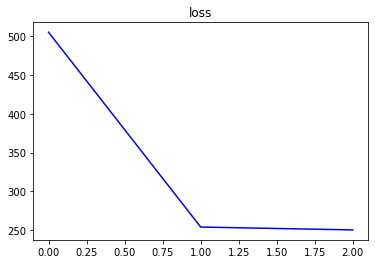

In [156]:
plt.title("loss")
plt.plot(range(len(count_loss)), count_loss, color='blue')
plt.show()